# Benchmarking feature selection algorithms in the molecular property prediction space

*Alejandro Corrochano's contribution to AstraZeneca's supervised project 'Benchmarking feature selection algorithms in the molecular prediction space'*

In [1]:
# Datasets
from tdc.single_pred import ADME, Tox

# Additional functions in a separate ipynb file
from ipynb.fs.full.AZ_additional_functions import *

# General use 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import shap
import joblib

import scipy
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# RDkit
from rdkit import Chem
from rdkit import RDLogger
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Standardizing
from molvs import standardize_smiles

In [22]:
benchmark = []

## Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

In [2]:
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
data_overview(df, split_LIPO)

Total number of molecules: 4200
Train set: 2940 - 70.0%
Validation set: 420 - 10.0%
Test set: 840 - 20.0%


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


In [4]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified: {}'.format(len(frag_compounds)))

Number of compounds modified: 1


In [5]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
Shape: (4200, 3)


### Descriptors
Contain numerical information regarding the molecule 

In [6]:
descList = [i for i,j in Descriptors.descList]
#Molecular descriptor calculator
calculator = MolecularDescriptorCalculator(descList)
print('Total number of descriptors:', len(descList))

Total number of descriptors: 208


In [7]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

Actual shape of the Dataframe: (4200, 211)


In [8]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.10


### Fingerprints
Allows us to find patterns in molecule structures.

In [9]:
# FP_data = (num_mols x numVectorBits)
def generate_fingerprints(df):
    fp_data = []
    fp_arr = np.zeros((1,))

    for mol in df['Drug']:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(mol),2,1024)
        DataStructs.ConvertToNumpyArray(fp, fp_arr)
        fp_data.append(fp_arr)
    
    print('Current shape of the fingerprint dataset:',len(fp_data),'x',len(fp_data[0]))
    
    return fp_data

In [10]:
# Generate fingerprints dataset and transform into a dataframe
fingerprints = generate_fingerprints(df)
fps = pd.DataFrame(fingerprints, columns = np.arange(1,1025))

Current shape of the fingerprint dataset: 4200 x 1024


### Generate splits, remove NaNs, and normalization
Lorem impsum

#### Train, validation, and test sets for both Descriptors and fingerprints

In [11]:
X_train, X_train_fps, y_train, X_val, X_val_fps, y_val, X_test, X_test_fps, y_test = train_val_test_split(df, split_LIPO, fps)

Data has been split


#### Remove NaNs values

In [12]:
X_train, X_train_fps, y_train, X_val, X_val_fps, X_test, y_test = remove_nans(X_train, X_val, X_test, y_train, y_val, y_test, X_train_fps, X_val_fps)

Removed the following rows in the train set: 1561


#### Data normalization required in linear models

In [13]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


## Data visualization

In [ ]:
#We now count the number of Zeros in each column

threshold = 3500
#Columns that contain zero values
desc_name = df.columns[(df == 0).sum(axis=0) > 0]
desc_count = (df[df.columns[(df == 0).sum(axis=0) > 0]] == 0).sum(axis=0)

color = ['red' if i > threshold else 'black' for i in desc_count]
size = [80 if i > threshold else 30 for i in desc_count]

# Scatter plot
fig, ax = plt.subplots();
ax.scatter(np.arange(len(desc_name)), desc_count, c=color, s=size)
plt.title('Number of zeros contained in the DF for each descriptor')
plt.xlabel('Descriptor index')
plt.ylabel('Zero values count')
fig.set_size_inches(20, 10);

for i in np.arange(len(desc_name)):
    ax.annotate(i, (i, desc_count[i]), rotation=15)
    
plt.show()

In [ ]:
# Visualize data distribution in traning and validation datasets

fig, ax = plt.subplots(figsize=(10,5))

for ind, a in enumerate([y_train, y_val]):
    if ind == 0:
        sns.distplot(a, ax=ax, label = 'Training')
    else:
        sns.distplot(a, ax=ax, label = 'Validation')

plt.xlabel('Y values')
plt.title('Distribution of target values in training and validation sets') 
plt.legend(loc = 'best')
plt.show()

## Building our baseline models

In order to get some initial results, we will now construct a few baseline models where all the features are included without any preprocessing.

We now compare the metrics obtained for each of the following models:
- Linear regression (**LR**)
- Random forest regressor (**RFR**)
- Decision tree regressor (**DTR**)
- Support vector machine (**SVM**)
- Multi-layer Perceptron regressor (**MLP**)

#### Descriptors

LR | R2: 0.599, MAE: 0.594, MSE: 0.597
RFR | R2: 0.646, MAE: 0.546, MSE: 0.527
DTR | R2: 0.260, MAE: 0.775, MSE: 1.102
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463
MLPR | R2: 0.652, MAE: 0.514, MSE: 0.517


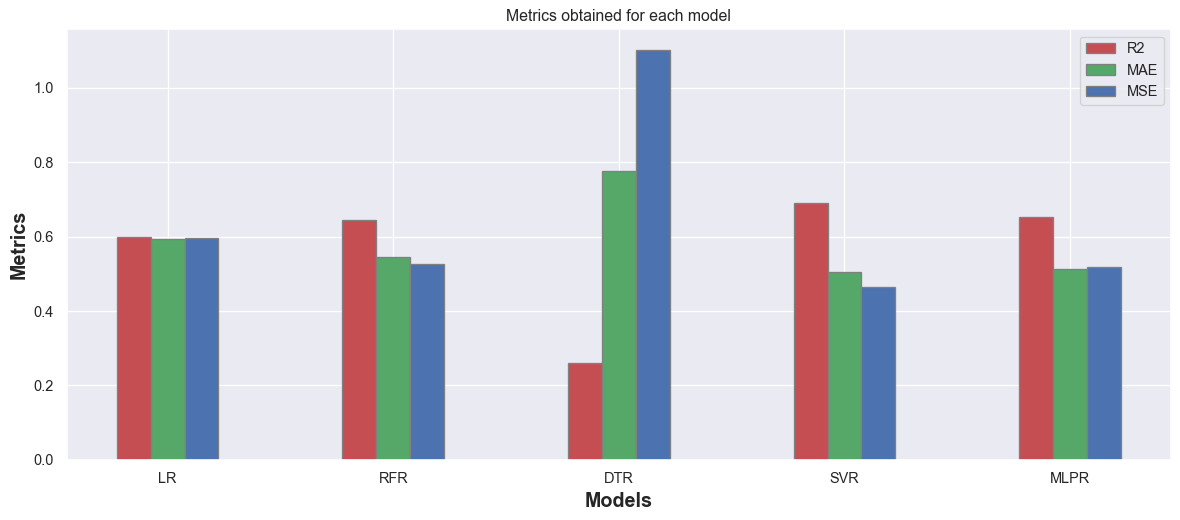

In [20]:
models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, False, X_train_norm, X_val_norm)

In [23]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

#### Fingerprints

In [ ]:
# models, results = models_comparison(X_train, y_train, X_val, y_val, False, True, True)

## Improving the model 

### Improving the model: Feature Selection - MRMR

In [24]:
models, results, num_sel_feat, features = fs_mrmr(X_train, y_train, X_val, y_val, X_train_norm, X_val_norm)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 22.43it/s]


LR | R2: -0.006, MAE: 0.997, MSE: 1.497
RFR | R2: -0.055, MAE: 0.956, MSE: 1.571
DTR | R2: -0.387, MAE: 1.077, MSE: 2.064
SVR | R2: -0.035, MAE: 0.994, MSE: 1.541
MLPR | R2: -0.006, MAE: 0.994, MSE: 1.497


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 33.94it/s]


LR | R2: -0.005, MAE: 0.996, MSE: 1.496
RFR | R2: -0.049, MAE: 0.952, MSE: 1.562
DTR | R2: -0.393, MAE: 1.081, MSE: 2.073
SVR | R2: -0.032, MAE: 0.991, MSE: 1.536
MLPR | R2: -0.009, MAE: 0.999, MSE: 1.502


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 35.02it/s]


LR | R2: 0.114, MAE: 0.937, MSE: 1.319
RFR | R2: 0.119, MAE: 0.867, MSE: 1.312
DTR | R2: -0.184, MAE: 0.994, MSE: 1.762
SVR | R2: 0.090, MAE: 0.930, MSE: 1.355
MLPR | R2: 0.086, MAE: 0.946, MSE: 1.360


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 36.82it/s]


LR | R2: 0.120, MAE: 0.931, MSE: 1.310
RFR | R2: 0.133, MAE: 0.862, MSE: 1.290
DTR | R2: -0.222, MAE: 0.995, MSE: 1.819
SVR | R2: 0.090, MAE: 0.929, MSE: 1.355
MLPR | R2: 0.104, MAE: 0.941, MSE: 1.333


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 37.30it/s]


LR | R2: 0.359, MAE: 0.790, MSE: 0.955
RFR | R2: 0.404, MAE: 0.722, MSE: 0.887
DTR | R2: 0.030, MAE: 0.881, MSE: 1.444
SVR | R2: 0.362, MAE: 0.765, MSE: 0.950
MLPR | R2: 0.386, MAE: 0.754, MSE: 0.914


100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 34.14it/s]


LR | R2: 0.384, MAE: 0.767, MSE: 0.917
RFR | R2: 0.466, MAE: 0.687, MSE: 0.794
DTR | R2: 0.159, MAE: 0.808, MSE: 1.252
SVR | R2: 0.381, MAE: 0.741, MSE: 0.922
MLPR | R2: 0.400, MAE: 0.731, MSE: 0.892


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 36.84it/s]


LR | R2: 0.389, MAE: 0.766, MSE: 0.910
RFR | R2: 0.473, MAE: 0.687, MSE: 0.784
DTR | R2: 0.114, MAE: 0.850, MSE: 1.319
SVR | R2: 0.403, MAE: 0.731, MSE: 0.889
MLPR | R2: 0.401, MAE: 0.729, MSE: 0.891


100%|███████████████████████████████████████████| 45/45 [00:01<00:00, 36.33it/s]


LR | R2: 0.400, MAE: 0.758, MSE: 0.893
RFR | R2: 0.485, MAE: 0.672, MSE: 0.766
DTR | R2: 0.152, MAE: 0.838, MSE: 1.262
SVR | R2: 0.421, MAE: 0.715, MSE: 0.862
MLPR | R2: 0.444, MAE: 0.705, MSE: 0.828


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 38.06it/s]


LR | R2: 0.409, MAE: 0.753, MSE: 0.880
RFR | R2: 0.468, MAE: 0.677, MSE: 0.792
DTR | R2: 0.013, MAE: 0.898, MSE: 1.469
SVR | R2: 0.440, MAE: 0.697, MSE: 0.834
MLPR | R2: 0.402, MAE: 0.711, MSE: 0.890


100%|███████████████████████████████████████████| 55/55 [00:01<00:00, 36.84it/s]


LR | R2: 0.409, MAE: 0.746, MSE: 0.879
RFR | R2: 0.521, MAE: 0.645, MSE: 0.713
DTR | R2: 0.061, MAE: 0.879, MSE: 1.398
SVR | R2: 0.456, MAE: 0.672, MSE: 0.810
MLPR | R2: 0.372, MAE: 0.701, MSE: 0.935


100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 38.62it/s]


LR | R2: 0.429, MAE: 0.732, MSE: 0.849
RFR | R2: 0.551, MAE: 0.623, MSE: 0.668
DTR | R2: 0.129, MAE: 0.830, MSE: 1.296
SVR | R2: 0.490, MAE: 0.645, MSE: 0.760
MLPR | R2: 0.394, MAE: 0.701, MSE: 0.901


100%|███████████████████████████████████████████| 65/65 [00:01<00:00, 36.57it/s]


LR | R2: 0.448, MAE: 0.721, MSE: 0.821
RFR | R2: 0.559, MAE: 0.618, MSE: 0.656
DTR | R2: 0.199, MAE: 0.799, MSE: 1.193
SVR | R2: 0.509, MAE: 0.633, MSE: 0.731
MLPR | R2: 0.438, MAE: 0.675, MSE: 0.837


100%|███████████████████████████████████████████| 70/70 [00:01<00:00, 39.22it/s]


LR | R2: 0.471, MAE: 0.703, MSE: 0.787
RFR | R2: 0.576, MAE: 0.606, MSE: 0.631
DTR | R2: 0.232, MAE: 0.789, MSE: 1.144
SVR | R2: 0.566, MAE: 0.600, MSE: 0.647
MLPR | R2: 0.463, MAE: 0.642, MSE: 0.800


100%|███████████████████████████████████████████| 75/75 [00:02<00:00, 37.11it/s]


LR | R2: 0.481, MAE: 0.692, MSE: 0.772
RFR | R2: 0.601, MAE: 0.585, MSE: 0.594
DTR | R2: 0.212, MAE: 0.799, MSE: 1.173
SVR | R2: 0.585, MAE: 0.584, MSE: 0.618
MLPR | R2: 0.580, MAE: 0.567, MSE: 0.625


100%|███████████████████████████████████████████| 80/80 [00:02<00:00, 34.34it/s]


LR | R2: 0.488, MAE: 0.690, MSE: 0.762
RFR | R2: 0.611, MAE: 0.578, MSE: 0.578
DTR | R2: 0.286, MAE: 0.772, MSE: 1.063
SVR | R2: 0.595, MAE: 0.578, MSE: 0.603
MLPR | R2: 0.537, MAE: 0.601, MSE: 0.690


100%|███████████████████████████████████████████| 85/85 [00:02<00:00, 34.65it/s]


LR | R2: 0.496, MAE: 0.685, MSE: 0.750
RFR | R2: 0.614, MAE: 0.581, MSE: 0.574
DTR | R2: 0.176, MAE: 0.814, MSE: 1.226
SVR | R2: 0.611, MAE: 0.568, MSE: 0.579
MLPR | R2: 0.555, MAE: 0.589, MSE: 0.662


100%|███████████████████████████████████████████| 90/90 [00:02<00:00, 38.27it/s]


LR | R2: 0.510, MAE: 0.674, MSE: 0.729
RFR | R2: 0.611, MAE: 0.576, MSE: 0.579
DTR | R2: 0.343, MAE: 0.746, MSE: 0.977
SVR | R2: 0.630, MAE: 0.555, MSE: 0.551
MLPR | R2: 0.566, MAE: 0.591, MSE: 0.646


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 41.29it/s]


LR | R2: 0.521, MAE: 0.665, MSE: 0.713
RFR | R2: 0.620, MAE: 0.568, MSE: 0.565
DTR | R2: 0.302, MAE: 0.764, MSE: 1.040
SVR | R2: 0.639, MAE: 0.545, MSE: 0.537
MLPR | R2: 0.624, MAE: 0.554, MSE: 0.559


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 41.58it/s]


LR | R2: 0.543, MAE: 0.640, MSE: 0.680
RFR | R2: 0.631, MAE: 0.555, MSE: 0.549
DTR | R2: 0.258, MAE: 0.771, MSE: 1.104
SVR | R2: 0.655, MAE: 0.529, MSE: 0.514
MLPR | R2: 0.624, MAE: 0.539, MSE: 0.559


100%|█████████████████████████████████████████| 105/105 [00:02<00:00, 40.92it/s]


LR | R2: 0.563, MAE: 0.628, MSE: 0.650
RFR | R2: 0.629, MAE: 0.556, MSE: 0.552
DTR | R2: 0.322, MAE: 0.752, MSE: 1.010
SVR | R2: 0.663, MAE: 0.524, MSE: 0.501
MLPR | R2: 0.619, MAE: 0.533, MSE: 0.567


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.27it/s]


LR | R2: 0.567, MAE: 0.625, MSE: 0.645
RFR | R2: 0.633, MAE: 0.553, MSE: 0.547
DTR | R2: 0.159, MAE: 0.841, MSE: 1.251
SVR | R2: 0.666, MAE: 0.521, MSE: 0.497
MLPR | R2: 0.612, MAE: 0.535, MSE: 0.578


100%|█████████████████████████████████████████| 115/115 [00:02<00:00, 42.88it/s]


LR | R2: 0.570, MAE: 0.623, MSE: 0.641
RFR | R2: 0.635, MAE: 0.552, MSE: 0.543
DTR | R2: 0.236, MAE: 0.791, MSE: 1.137
SVR | R2: 0.672, MAE: 0.518, MSE: 0.488
MLPR | R2: 0.547, MAE: 0.585, MSE: 0.674


100%|█████████████████████████████████████████| 120/120 [00:02<00:00, 41.65it/s]


LR | R2: 0.563, MAE: 0.628, MSE: 0.651
RFR | R2: 0.634, MAE: 0.549, MSE: 0.545
DTR | R2: 0.222, MAE: 0.783, MSE: 1.157
SVR | R2: 0.673, MAE: 0.517, MSE: 0.486
MLPR | R2: 0.624, MAE: 0.538, MSE: 0.560


100%|█████████████████████████████████████████| 125/125 [00:03<00:00, 41.37it/s]


LR | R2: 0.566, MAE: 0.626, MSE: 0.647
RFR | R2: 0.635, MAE: 0.556, MSE: 0.544
DTR | R2: 0.210, MAE: 0.805, MSE: 1.176
SVR | R2: 0.670, MAE: 0.522, MSE: 0.492
MLPR | R2: 0.614, MAE: 0.544, MSE: 0.574


100%|█████████████████████████████████████████| 130/130 [00:03<00:00, 43.10it/s]


LR | R2: 0.569, MAE: 0.624, MSE: 0.642
RFR | R2: 0.630, MAE: 0.558, MSE: 0.551
DTR | R2: 0.210, MAE: 0.795, MSE: 1.176
SVR | R2: 0.670, MAE: 0.522, MSE: 0.491
MLPR | R2: 0.642, MAE: 0.538, MSE: 0.533


100%|█████████████████████████████████████████| 135/135 [00:03<00:00, 40.44it/s]


LR | R2: 0.572, MAE: 0.614, MSE: 0.637
RFR | R2: 0.643, MAE: 0.550, MSE: 0.532
DTR | R2: 0.248, MAE: 0.781, MSE: 1.119
SVR | R2: 0.678, MAE: 0.515, MSE: 0.480
MLPR | R2: 0.654, MAE: 0.519, MSE: 0.514


100%|█████████████████████████████████████████| 140/140 [00:03<00:00, 43.37it/s]


LR | R2: 0.584, MAE: 0.608, MSE: 0.620
RFR | R2: 0.643, MAE: 0.549, MSE: 0.531
DTR | R2: 0.223, MAE: 0.803, MSE: 1.156
SVR | R2: 0.680, MAE: 0.511, MSE: 0.476
MLPR | R2: 0.600, MAE: 0.554, MSE: 0.596


100%|█████████████████████████████████████████| 145/145 [00:03<00:00, 40.64it/s]


LR | R2: 0.577, MAE: 0.614, MSE: 0.630
RFR | R2: 0.639, MAE: 0.557, MSE: 0.537
DTR | R2: 0.211, MAE: 0.798, MSE: 1.174
SVR | R2: 0.681, MAE: 0.510, MSE: 0.475
MLPR | R2: 0.641, MAE: 0.536, MSE: 0.534


100%|█████████████████████████████████████████| 150/150 [00:03<00:00, 44.34it/s]


LR | R2: 0.590, MAE: 0.605, MSE: 0.610
RFR | R2: 0.639, MAE: 0.554, MSE: 0.537
DTR | R2: 0.214, MAE: 0.788, MSE: 1.170
SVR | R2: 0.685, MAE: 0.506, MSE: 0.468
MLPR | R2: 0.606, MAE: 0.551, MSE: 0.586


100%|█████████████████████████████████████████| 155/155 [00:03<00:00, 43.74it/s]


LR | R2: 0.596, MAE: 0.600, MSE: 0.602
RFR | R2: 0.637, MAE: 0.556, MSE: 0.541
DTR | R2: 0.272, MAE: 0.743, MSE: 1.084
SVR | R2: 0.687, MAE: 0.505, MSE: 0.466
MLPR | R2: 0.594, MAE: 0.560, MSE: 0.604


100%|█████████████████████████████████████████| 160/160 [00:03<00:00, 42.35it/s]


LR | R2: 0.594, MAE: 0.603, MSE: 0.604
RFR | R2: 0.639, MAE: 0.554, MSE: 0.537
DTR | R2: 0.267, MAE: 0.755, MSE: 1.091
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.664, MAE: 0.507, MSE: 0.501


100%|█████████████████████████████████████████| 165/165 [00:03<00:00, 43.94it/s]


LR | R2: 0.594, MAE: 0.602, MSE: 0.605
RFR | R2: 0.640, MAE: 0.552, MSE: 0.536
DTR | R2: 0.199, MAE: 0.799, MSE: 1.193
SVR | R2: 0.694, MAE: 0.502, MSE: 0.456
MLPR | R2: 0.616, MAE: 0.545, MSE: 0.571


100%|█████████████████████████████████████████| 170/170 [00:03<00:00, 43.99it/s]


LR | R2: 0.589, MAE: 0.601, MSE: 0.612
RFR | R2: 0.639, MAE: 0.551, MSE: 0.537
DTR | R2: 0.232, MAE: 0.778, MSE: 1.143
SVR | R2: 0.693, MAE: 0.501, MSE: 0.456
MLPR | R2: 0.666, MAE: 0.506, MSE: 0.497


100%|█████████████████████████████████████████| 175/175 [00:03<00:00, 45.43it/s]


LR | R2: 0.573, MAE: 0.605, MSE: 0.635
RFR | R2: 0.640, MAE: 0.550, MSE: 0.535
DTR | R2: 0.268, MAE: 0.768, MSE: 1.090
SVR | R2: 0.693, MAE: 0.500, MSE: 0.457
MLPR | R2: 0.638, MAE: 0.526, MSE: 0.539


100%|█████████████████████████████████████████| 180/180 [00:03<00:00, 46.33it/s]


LR | R2: 0.572, MAE: 0.606, MSE: 0.638
RFR | R2: 0.643, MAE: 0.548, MSE: 0.532
DTR | R2: 0.320, MAE: 0.731, MSE: 1.012
SVR | R2: 0.691, MAE: 0.502, MSE: 0.461
MLPR | R2: 0.602, MAE: 0.555, MSE: 0.592


100%|█████████████████████████████████████████| 185/185 [00:03<00:00, 48.51it/s]


LR | R2: 0.578, MAE: 0.605, MSE: 0.628
RFR | R2: 0.642, MAE: 0.549, MSE: 0.533
DTR | R2: 0.365, MAE: 0.709, MSE: 0.944
SVR | R2: 0.690, MAE: 0.503, MSE: 0.462
MLPR | R2: 0.673, MAE: 0.514, MSE: 0.487


100%|█████████████████████████████████████████| 190/190 [00:04<00:00, 47.34it/s]


LR | R2: 0.590, MAE: 0.596, MSE: 0.610
RFR | R2: 0.645, MAE: 0.548, MSE: 0.529
DTR | R2: 0.340, MAE: 0.731, MSE: 0.983
SVR | R2: 0.688, MAE: 0.504, MSE: 0.464
MLPR | R2: 0.597, MAE: 0.555, MSE: 0.599


100%|█████████████████████████████████████████| 195/195 [00:05<00:00, 34.85it/s]


LR | R2: 0.598, MAE: 0.593, MSE: 0.598
RFR | R2: 0.642, MAE: 0.550, MSE: 0.533
DTR | R2: 0.278, MAE: 0.771, MSE: 1.075
SVR | R2: 0.688, MAE: 0.504, MSE: 0.465
MLPR | R2: 0.634, MAE: 0.526, MSE: 0.544


100%|█████████████████████████████████████████| 197/197 [00:06<00:00, 29.66it/s]


LR | R2: 0.590, MAE: 0.603, MSE: 0.610
RFR | R2: 0.647, MAE: 0.547, MSE: 0.525
DTR | R2: 0.316, MAE: 0.751, MSE: 1.018
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537


100%|█████████████████████████████████████████| 197/197 [00:06<00:00, 30.86it/s]


LR | R2: 0.590, MAE: 0.603, MSE: 0.610
RFR | R2: 0.647, MAE: 0.547, MSE: 0.525
DTR | R2: 0.316, MAE: 0.751, MSE: 1.018
SVR | R2: 0.689, MAE: 0.503, MSE: 0.463
MLPR | R2: 0.639, MAE: 0.525, MSE: 0.537


We now plot the metrics obtained for each iteration

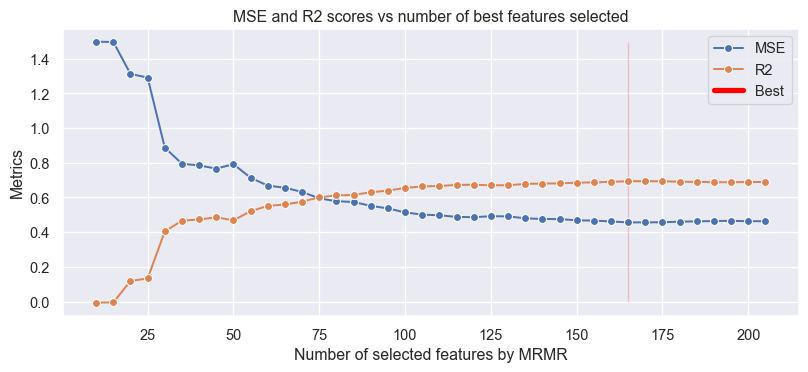

In [25]:
mse, r2 = [], []
for iteration in results:
    mse.append(min([mse[2] for mse in iteration]))
    r2.append(max([r2[0] for r2 in iteration]))

num_sel_feat = num_sel_feat = np.arange(10, X_train.shape[1], 5)

# Plot R2 and MSE 
plt.figure(figsize=(10, 4), dpi = 95)
sns.set_theme(style="darkgrid")

sns.lineplot(x = num_sel_feat, y = mse, marker='o', label = 'MSE')
sns.lineplot(x = num_sel_feat, y = r2, marker='o', label = 'R2')
# Vertical line to indicate best performance
sns.lineplot([num_sel_feat[np.argmax(r2)], num_sel_feat[np.argmax(r2)]], [0, max(mse)], 
             color = 'red',linewidth = 4, label = 'Best')
plt.legend()
plt.title('MSE and R2 scores vs number of best features selected')
plt.xlabel('Number of selected features by MRMR')
plt.ylabel('Metrics')
plt.show()

Best performance occurs when the number of selected features is **165**. Once again, model that better performs is **SVR**, with the following metrics: **R2: 0.693, MAE: 0.502, MSE: 0.456**. This means there is a **0.05** improvement in the R2 score while using **43** features less.

In [26]:
# Take selected features by MRMR
selected_features_mrmr = features[np.argmax(r2)]

# features_20 = features[2]
# print(features_20)

Apply randomizedSearchCV()

In [34]:
rnd_models_mrmr, metrics_rnd_mrmr = apply_randsearch(X_train[selected_features_mrmr]
                                                        , y_train                                                       
                                                        , X_val[selected_features_mrmr]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[selected_features_mrmr]
                                                        , X_val_norm[selected_features_mrmr])

{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'coef0': 0.01, 'C': 5}
r2: 0.748425, mse: 0.374455, mae: 0.447647


### Improving the model: Manual data cleaning

#### Pipeline
- Remove **MolLogP** and **BCUT2D** features. 
- Remove **zero variance features**. 
- Remove **high correlated** features.

#### 1 - Remove MolLogP, BCUT2D, and zero variance features. 

In [35]:
#Remove MolLogP, BCUT2D, and features with zero variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selector.fit(X_train)

# Selector.get_support() returns a [,num_descriptors] boolean mask. False represents zero variance columns.
zero_var_cols = [column for column in X_train.columns
                    if column not in X_train.columns[selector.get_support()]]

print('There are {} columns with zero variance'.format(len(zero_var_cols)))

# As BCUT features and MolLogP may have counterproductive effects, we proceed to delete them
zero_var_cols.extend([col for col in df.columns if 'BCUT2D' in col or 'MolLogP' in col])

# We drop this first set of 11 columns in each set. 
# for i in [X_train, X_train_norm, X_val, X_val_norm]:
#     i.drop(zero_var_cols, axis = 1, inplace = True)

print('Total number of features dropped:', len(zero_var_cols))

There are 10 columns with zero variance
Total number of features dropped: 19


#### 2 - Remove high correlated features

In [36]:
# We drop the features with a high correlation

corr = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than X
correlated_features = [col for col in upper.columns if any(upper[col] > 0.95)]

print('Number of correlated features deleted: {}'.format(len(correlated_features)))

Number of correlated features deleted: 29


In [44]:
# We group all the dropped features
mc_cols = list(set(X_train.columns) - set(correlated_features + zero_var_cols))

print('Total number of remaining descriptors after the data cleaning: {}'.format(len(mc_cols)))

Total number of remaining descriptors after the data cleaning: 159


### Models comparison after data cleaning

LR | R2: 0.561, MAE: 0.613, MSE: 0.653
RFR | R2: 0.603, MAE: 0.578, MSE: 0.591
DTR | R2: 0.209, MAE: 0.808, MSE: 1.178
SVR | R2: 0.690, MAE: 0.502, MSE: 0.462
MLPR | R2: 0.600, MAE: 0.558, MSE: 0.596


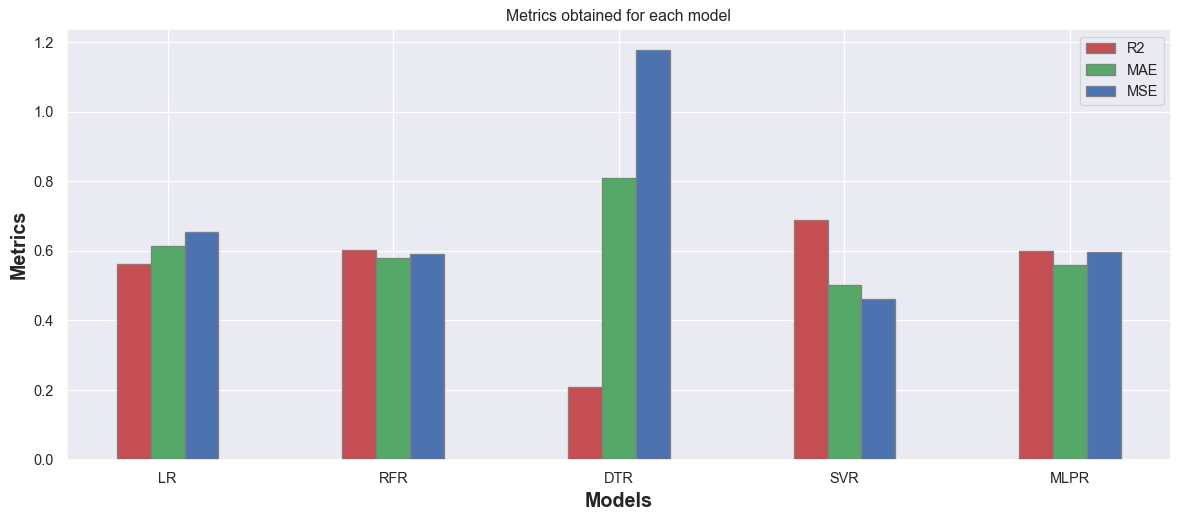

In [45]:
models, results = models_comparison(X_train[mc_cols]
                                    , y_train
                                    , X_val[mc_cols]
                                    , y_val
                                    , False
                                    , True
                                    , False
                                    , X_train_norm[mc_cols]
                                    , X_val_norm[mc_cols])

In [ ]:
#We add the best model to our benchmark for a later comparison
benchmark = add_to_benchmark(benchmark, models, results)

In [ ]:
rnd_models_mc, metrics_rnd_mc = apply_randsearch(X_train[mc_cols]
                                                        , y_train                                                       
                                                        , X_val[mc_cols]
                                                        , y_val
                                                        , False
                                                        , X_train_norm[mc_cols]
                                                        , X_val_norm[mc_cols])

### Exploring alternatives: RandomizedSearchCV() in potential candidates

By making use of RandomizedSearchCV() we could perhaps obtain better metrics in our potential model candidates  SVR and RFR. Function combines randomly the given hyperparameters to adjust the tuning. 

In [32]:
def apply_randsearch(X_train, y_train, X_val, y_val, c,  X_train_norm = 0 , X_val_norm = 0):
    np.random.seed(10)

#     grid_param_rfr = {
#         'n_estimators': [200, 250, 300],
#         'max_depth': [10, 20, 30, 40, None],
#         'max_features': ['auto', 'sqrt', 'log2'],
#         'min_samples_split': [2, 5, 10, 15],
#         'min_samples_leaf': [1, 2, 5, 10],
#         'bootstrap': [True, False]
#     }

    grid_param_svr = {'kernel' : ['rbf'],
                      'C' : [1,5,10],
                      'degree' : [3,8],
                      'coef0' : [0.01,10,0.5],
                      'gamma' : ('auto','scale')
                     }
    
#     (grid_param_rfr, RandomForestRegressor()),
    rnd_models = []
    for grid in [(grid_param_svr, SVR())]:
        random_model = RandomizedSearchCV(grid[1], param_distributions = grid[0], n_iter = 300, cv = 5, n_jobs = -1)
        rnd_models.append(random_model)

    # Fit the model
    for ind, m in enumerate(rnd_models):
#         if ind == 0:
#             rnd_models[ind] = m.fit(X_train, y_train)
#         else:
        rnd_models[ind] = m.fit(X_train_norm, y_train)
    
    # Once models are trained we compute the metrics 
    for i in range(len(rnd_models)):
        print(rnd_models[i].best_params_)
        temp_clf = rnd_models[i].best_estimator_
    
        #Predict values 
#         if i == 0:
#             y_pred = temp_clf.predict(X_val)
#         else:
        y_pred = temp_clf.predict(X_val_norm)

        #Compute metrics 
        r2 = metrics.r2_score(y_val, y_pred)
        mae = metrics.mean_absolute_error(y_val, y_pred)
        mse = metrics.mean_squared_error(y_val, y_pred)
        print('r2: %f, mse: %f, mae: %f' %(r2, mse, mae))
    
    return rnd_models, (r2, mse, mae)

In [49]:
rnd_models, metrics = apply_randsearch(X_train, X_train_norm, y_train, X_val, False, X_val_norm, y_val)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
r2: 0.615016, mse: 0.567483, mae: 0.573027
{'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'coef0': 0.01, 'C': 5}
r2: 0.743075, mse: 0.447705, mae: 0.382419


In [113]:
# Save the model 
joblib.dump(rnd_models[1], 'svr_manual_clean.pkl')

# Loading model
svr_manual_clean = joblib.load('svr_manual_clean.pkl')

# Ames mutagenicity 
Mutagenicity means the ability of a drug to induce genetic alterations. Drugs that can cause damage to the DNA can result in cell death or other severe adverse effects

In [35]:
data = Tox(name = 'AMES')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_AMES = data.get_split()

Found local copy...
Loading...
Done!


In [36]:
data_overview(df, split_AMES)

Total number of molecules: 7278
Train set: 5094 - 70.0%
Validation set: 728 - 10.0%
Test set: 1456 - 20.0%


,Drug_ID,Drug,Y
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1


In [37]:
# Remove fragments of compounds that may contain them
frag_compounds = [comp for comp in df['Drug'] if len(comp.split('.')) > 1]
for ind, c in enumerate(frag_compounds):
    df.loc[df.Drug == frag_compounds[ind], 'Drug'] = frag_compounds[ind].split('.')[0]

print('Number of compounds modified:{}'.format(len(frag_compounds)))

Number of compounds modified:0


In [38]:
# Duplicates and compounds with less than 5 heavy atoms removal
df = remove_ha_duplicates(df)

Duplicated compounds and with less than 5 heavy atoms have been removed.
Shape: (7140, 3)


In [40]:
# Standardize the molecules 
df['Drug'] = [standardize_smiles(smi) for smi in df['Drug']]

# Generate a list of lists where each row corresponds to a molecule and each column to a descriptor (transpose step required)
c = [calculator.CalcDescriptors(Chem.MolFromSmiles(smi)) for smi in df['Drug']]

# Convert it into a numpy array and transpose it so the columns represent the descriptors
c = np.asarray(c).transpose()

# Append all the descriptors to the DF
for i, descriptor in enumerate(descList):
    df[descriptor] = c[i]
    
#We move the target (Ames) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

print('Actual shape of the Dataframe:', df.shape)

RDKit ERROR: [19:18:03] Can't kekulize mol.  Unkekulized atoms: 0 4 7 8 9
[19:18:03] Can't kekulize mol.  Unkekulized atoms: 0 4 7 8 9

RDKit ERROR: 


Actual shape of the Dataframe: (7140, 211)


In [41]:
df.head()

,Drug_ID,Drug,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310,332.230,342.064057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,11.824743,-0.170602,11.824743,0.170602,0.269289,301.345,286.225,301.110279,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,14.431073,-0.378575,14.431073,0.128988,0.184582,646.614,628.470,646.116486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,10.422197,-0.670278,10.422197,0.248657,0.103849,157.133,150.077,157.059974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,10.521759,-0.752407,10.521759,0.278148,0.342148,138.086,136.070,138.017775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [42]:
# Generate fingerprints dataset and transform into a dataframe
fingerprints = generate_fingerprints(df)
fps = pd.DataFrame(fingerprints, columns = np.arange(1,1025))

Current shape of the fingerprint dataset: 7140 x 1024


In [43]:
nan_mols = df.isnull().any(axis=1)
nan_mols[nan_mols == True]
df.dropna(inplace = True)

0       False
1       False
2       False
3       False
4       False
        ...  
7273    False
7274    False
7275    False
7276    False
7277    False
Length: 7140, dtype: bool


In [44]:
X_train, X_train_fps, y_train, X_val, X_val_fps, y_val, X_test, X_test_fps, y_test = train_val_test_split(df, split_AMES, fps)

Data has been split


In [45]:
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

Data is now normalized.


### Check balance of dataset/split

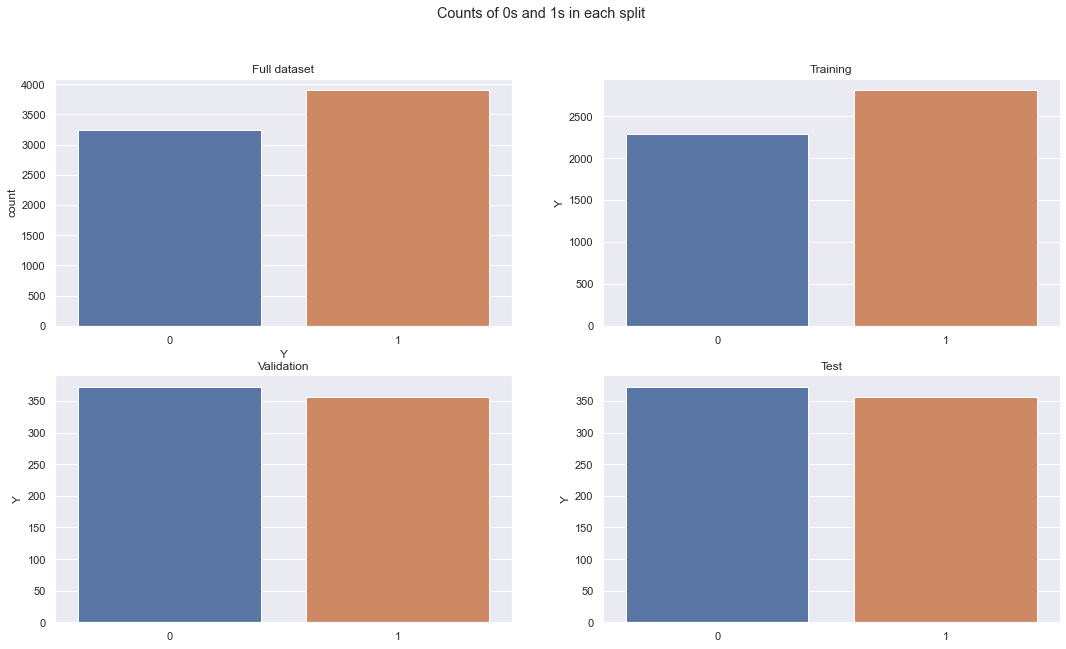

In [46]:
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Counts of 0s and 1s in each split')

sns.countplot(x="Y",ax=axes[0, 0], data = df, label = 'Complete dataset')
axes[0, 0].set_title('Full dataset')
sns.barplot(ax=axes[0, 1], x= y_train.value_counts().index, y= y_train.value_counts(), label= 'Training')
axes[0, 1].set_title('Training')
sns.barplot(ax=axes[1, 0], x= y_val.value_counts().index, y= y_val.value_counts(), label = 'Validation')
axes[1, 0].set_title('Validation')
sns.barplot(ax=axes[1, 1], x= y_val.value_counts().index, y= y_val.value_counts(), label = 'Test')
axes[1, 1].set_title('Test')
plt.show()

## Building our baseline models

MLPC | MCC: 0.592, AUC: 0.796, Accuracy: 0.772, Precision: 0.826, Recall: 0.795
SVC | MCC: 0.575, AUC: 0.787, Accuracy: 0.769, Precision: 0.806, Recall: 0.787
RFC | MCC: 0.632, AUC: 0.816, Accuracy: 0.807, Precision: 0.820, Recall: 0.816
DTC | MCC: 0.473, AUC: 0.736, Accuracy: 0.723, Precision: 0.747, Recall: 0.736
LG | MCC: 0.000, AUC: 0.500, Accuracy: 0.000, Precision: 0.000, Recall: 0.511


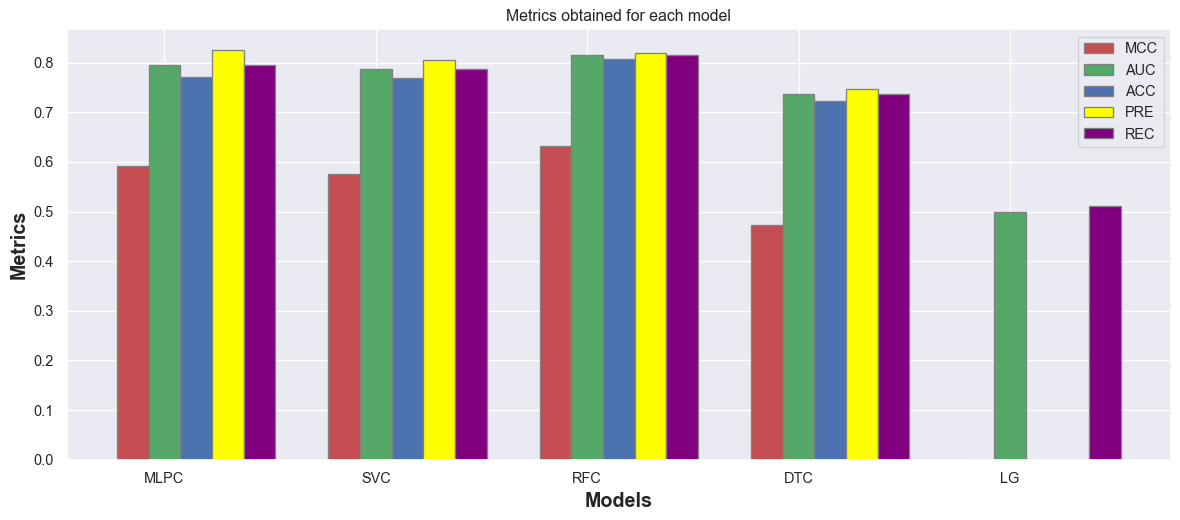

In [48]:
models, results = models_comparison(X_train, y_train, X_val, y_val, True,True, False, X_train_norm, X_val_norm)